Mount Google Drive and Setup Paths

In [ ]:
from google.colab import drive
from pathlib import Path
import os

print(">>> Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# --- Define paths ---
zip_path = Path("/content/drive/My Drive/Basil_train/Basil_genovese.zip")
extract_path = Path("/content/Basil_genovese")

# Unzip dataset
if not extract_path.exists():
    print(f">>> Unzipping {zip_path}...")
    os.system(f'unzip -oq "{zip_path}" -d "/content/"')
    print(">>> Unzipping complete!")
else:
    print(">>> Dataset already extracted.")

# Verify original structure
print("\n>>> Original dataset structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(str(extract_path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level >= 2:
        img_count = len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if img_count > 0:
            print(f'{indent}  -> {img_count} images')

>>> Mounting Google Drive...
Mounted at /content/drive
>>> Unzipping /content/drive/My Drive/Basil_train/Basil_genovese.zip...
>>> Unzipping complete!

>>> Original dataset structure:
Basil_genovese/
  Background/
  Basil_healthy/
  Real_disease/
    Basil_fungal/
      -> 129 images
    Basil_Mite/
      -> 70 images
    basil_miner/
      -> 40 images
    basil_growup_withered/
      -> 253 images
    Basil_leaf_curl/
      -> 25 images
  Proxy_disease/
    Tomato_Septoria_leaf_spot/
      -> 119 images
    Tomato_Spider_mites_Two_spotted_spider_mite/
      -> 120 images
    Tomato_Late_blight/
      -> 163 images
    Tomato__Target_Spot/
      -> 150 images


Flatten Dataset Structure for ImageFolder

In [ ]:
import shutil

flat_all_path = Path("/content/Basil_flat_all")

all_mapping = {
    "Background": "Background",
    "Basil_healthy": "Basil_healthy",
    "Real_disease/Basil_leaf_curl": "Disease_real",
    "Real_disease/basil_miner": "Disease_real",
    "Real_disease/Basil_fungal": "Disease_real",
    "Real_disease/basil_growup_withered": "Disease_real",
    "Real_disease/Basil_Mite": "Disease_real",
    "Proxy_disease/Tomato__Target_Spot": "Disease_proxy",
    "Proxy_disease/Tomato_Late_blight": "Disease_proxy",
    "Proxy_disease/Tomato_Spider_mites_Two_spotted_spider_mite": "Disease_proxy",
    "Proxy_disease/Tomato_Septoria_leaf_spot": "Disease_proxy",
}

if flat_all_path.exists():
    shutil.rmtree(flat_all_path)

for src_rel, target_class in all_mapping.items():
    src = extract_path / src_rel
    dst = flat_all_path / target_class
    dst.mkdir(parents=True, exist_ok=True)
    if src.is_dir():
        for img in src.iterdir():
            if img.is_file() and img.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                link = dst / f"{src_rel.replace('/', '_')}_{img.name}"
                if not link.exists():
                    os.symlink(img, link)

for d in sorted(flat_all_path.iterdir()):
    if d.is_dir():
        print(f"  {d.name}: {len(list(d.glob('*')))} images")

  Background: 464 images
  Basil_healthy: 429 images
  Disease_proxy: 552 images
  Disease_real: 517 images


Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import random
from PIL import Image
from tqdm.auto import tqdm

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda


Visualize Random Raw Images (Before Transform)

Total image files found: 1962


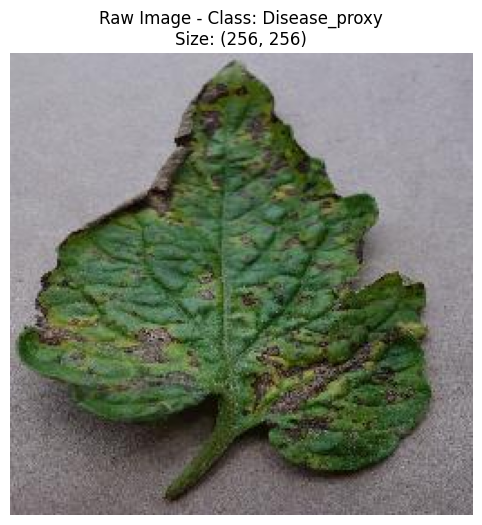

Image path: /content/Basil_flat_all/Disease_proxy/Proxy_disease_Tomato_Late_blight_img_2908.jpg
Image size: (256, 256)
Image class: Disease_proxy


In [ ]:
all_images = list(flat_all_path.glob("*/*.jpg")) + list(flat_all_path.glob("*/*.JPG")) + \
             list(flat_all_path.glob("*/*.png")) + list(flat_all_path.glob("*/*.PNG"))

print(f"Total image files found: {len(all_images)}")

# Display a single random image
random_image_path = random.choice(all_images)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

img_as_array = np.asarray(img)
plt.figure(figsize=(12, 6))
plt.imshow(img_as_array)
plt.xlabel(image_class)
plt.title(f"Raw Image - Class: {image_class}\nSize: {img.size}")
plt.axis(False)
plt.show()

print(f"Image path: {random_image_path}")
print(f"Image size: {img.size}")
print(f"Image class: {image_class}")

Define Transforms (Optimized for Basil Greenhouse)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Visualize Original vs Transformed Images

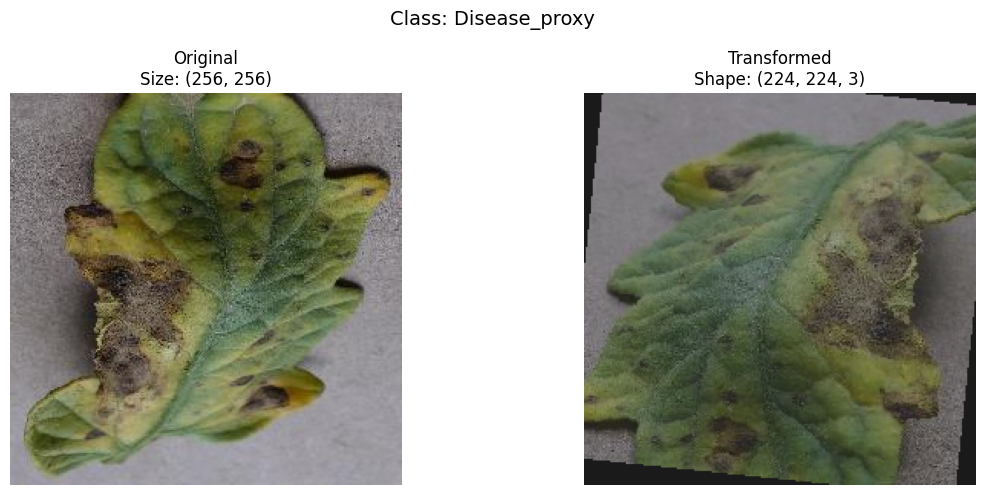

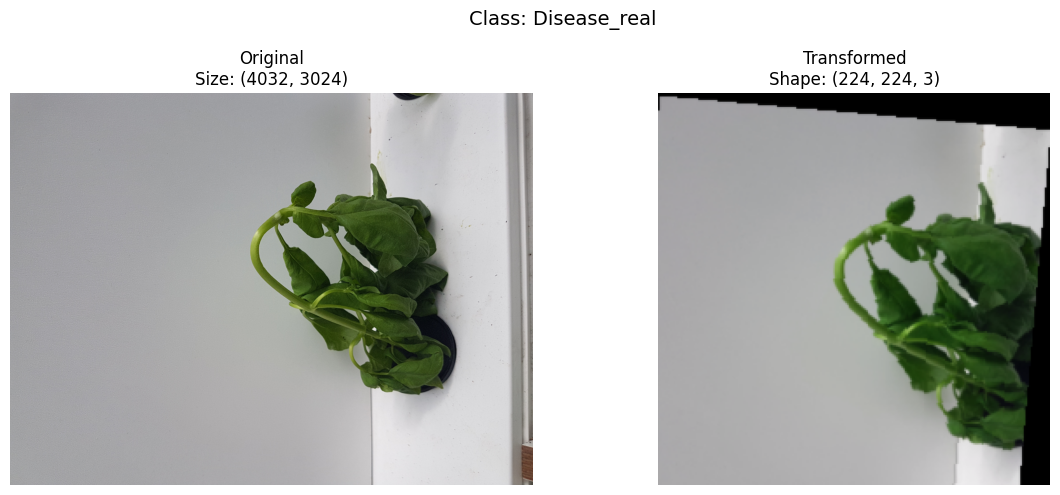

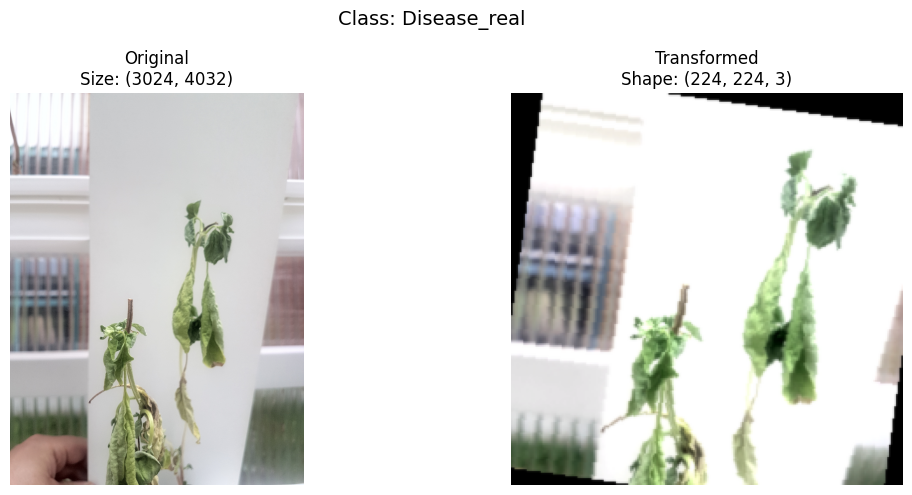

In [ ]:
def plot_transformed_image(image_paths, transform, n=3, seed=42):
    if seed:
        random.seed(seed)

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    random_paths = random.sample(image_paths, k=n)
    for image_path in random_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

            ax[0].imshow(img)
            ax[0].set_title(f"Original\nSize: {img.size}")
            ax[0].axis("off")

            transformed_tensor = transform(img)
            unnormalized = transformed_tensor.clone()
            for i in range(3):
                unnormalized[i] = unnormalized[i] * std[i] + mean[i]

            transformed_img = unnormalized.permute(1, 2, 0).numpy()
            transformed_img = np.clip(transformed_img, 0, 1)

            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\nShape: {transformed_img.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
            plt.tight_layout()
            plt.show()

plot_transformed_image(image_paths=all_images, transform=train_transform, n=3, seed=42)

Load Dataset and 70/15/15 Split

In [ ]:
# ============================================================
# Cell 7: Fixed Split - NO leakage
# ============================================================
from torch.utils.data import Subset, DataLoader
from PIL import Image
import numpy as np

# Step 1: Load everything
full_dataset = datasets.ImageFolder(root=flat_all_path)
print(f"All classes: {full_dataset.classes}")
print(f"Class to idx: {full_dataset.class_to_idx}")

# Step 2: Separate indices by class
bg_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Background']]
healthy_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Basil_healthy']]
real_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Disease_real']]
proxy_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Disease_proxy']]

print(f"\nBackground: {len(bg_idx)} | Healthy: {len(healthy_idx)} | Real Disease: {len(real_idx)} | Proxy Disease: {len(proxy_idx)}")

# Step 3: Split each non-proxy class into 70/15/15
np.random.seed(42)

def do_split(indices):
    idx = np.array(indices)
    np.random.shuffle(idx)
    n = len(idx)
    t = int(0.70 * n)
    v = int(0.85 * n)
    return idx[:t].tolist(), idx[t:v].tolist(), idx[v:].tolist()

bg_train, bg_val, bg_test = do_split(bg_idx)
hl_train, hl_val, hl_test = do_split(healthy_idx)
rd_train, rd_val, rd_test = do_split(real_idx)

# Test set: ALWAYS Background + Healthy + Real Disease (fixed)
test_indices = bg_test + hl_test + rd_test

# Val set: same
val_indices = bg_val + hl_val + rd_val

# ============================================================
# Train set: CHANGE THIS PER EXPERIMENT
# ============================================================

# Experiment A: Real Only
train_indices = bg_train + hl_train + rd_train

# # Experiment B: Real + Proxy
# train_indices = bg_train + hl_train + rd_train + proxy_idx

# ============================================================

# Step 4: Label mapping (4-class -> 3-class)
original_to_3class = {
    full_dataset.class_to_idx['Background']: 0,
    full_dataset.class_to_idx['Basil_healthy']: 1,
    full_dataset.class_to_idx['Disease_proxy']: 2,
    full_dataset.class_to_idx['Disease_real']: 2,
}

class FixedSubset(torch.utils.data.Dataset):
    def __init__(self, full_dataset, indices, transform, label_map):
        self.full_dataset = full_dataset
        self.indices = indices
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        path, original_label = self.full_dataset.samples[self.indices[idx]]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_map[original_label]
        return img, label

train_subset = FixedSubset(full_dataset, train_indices, train_transform, original_to_3class)
val_subset = FixedSubset(full_dataset, val_indices, test_transform, original_to_3class)
test_subset = FixedSubset(full_dataset, test_indices, test_transform, original_to_3class)

class_names = ['Background', 'Basil_healthy', 'Disease']
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 2

train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_subset, batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

print(f"\nTrain: {len(train_subset)} | Val: {len(val_subset)} | Test (fixed): {len(test_subset)}")
print(f"Classes: {class_names}")

All classes: ['Background', 'Basil_healthy', 'Disease_proxy', 'Disease_real']
Class to idx: {'Background': 0, 'Basil_healthy': 1, 'Disease_proxy': 2, 'Disease_real': 3}

Background: 464 | Healthy: 429 | Real Disease: 517 | Proxy Disease: 552

Train: 985 | Val: 212 | Test (fixed): 213
Classes: ['Background', 'Basil_healthy', 'Disease']


Realdataset + Proxy


In [ ]:
# ============================================================
# Cell 7: Fixed Split - NO leakage
# ============================================================
from torch.utils.data import Subset, DataLoader
from PIL import Image
import numpy as np

# Step 1: Load everything
full_dataset = datasets.ImageFolder(root=flat_all_path)
print(f"All classes: {full_dataset.classes}")
print(f"Class to idx: {full_dataset.class_to_idx}")

# Step 2: Separate indices by class
bg_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Background']]
healthy_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Basil_healthy']]
real_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Disease_real']]
proxy_idx = [i for i, (_, l) in enumerate(full_dataset.samples) if l == full_dataset.class_to_idx['Disease_proxy']]

print(f"\nBackground: {len(bg_idx)} | Healthy: {len(healthy_idx)} | Real Disease: {len(real_idx)} | Proxy Disease: {len(proxy_idx)}")

# Step 3: Split each non-proxy class into 70/15/15
np.random.seed(42)

def do_split(indices):
    idx = np.array(indices)
    np.random.shuffle(idx)
    n = len(idx)
    t = int(0.70 * n)
    v = int(0.85 * n)
    return idx[:t].tolist(), idx[t:v].tolist(), idx[v:].tolist()

bg_train, bg_val, bg_test = do_split(bg_idx)
hl_train, hl_val, hl_test = do_split(healthy_idx)
rd_train, rd_val, rd_test = do_split(real_idx)

# Test set: ALWAYS Background + Healthy + Real Disease (fixed)
test_indices = bg_test + hl_test + rd_test

# Val set: same
val_indices = bg_val + hl_val + rd_val

# ============================================================
# Train set: CHANGE THIS PER EXPERIMENT
# ============================================================

# Experiment A: Real Only
train_indices = bg_train + hl_train + rd_train + proxy_idx

# # Experiment B: Real + Proxy
# train_indices = bg_train + hl_train + rd_train + proxy_idx

# ============================================================

# Step 4: Label mapping (4-class -> 3-class)
original_to_3class = {
    full_dataset.class_to_idx['Background']: 0,
    full_dataset.class_to_idx['Basil_healthy']: 1,
    full_dataset.class_to_idx['Disease_proxy']: 2,
    full_dataset.class_to_idx['Disease_real']: 2,
}

class FixedSubset(torch.utils.data.Dataset):
    def __init__(self, full_dataset, indices, transform, label_map):
        self.full_dataset = full_dataset
        self.indices = indices
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        path, original_label = self.full_dataset.samples[self.indices[idx]]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_map[original_label]
        return img, label

train_subset = FixedSubset(full_dataset, train_indices, train_transform, original_to_3class)
val_subset = FixedSubset(full_dataset, val_indices, test_transform, original_to_3class)
test_subset = FixedSubset(full_dataset, test_indices, test_transform, original_to_3class)

class_names = ['Background', 'Basil_healthy', 'Disease']
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 2

train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_subset, batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

print(f"\nTrain: {len(train_subset)} | Val: {len(val_subset)} | Test (fixed): {len(test_subset)}")
print(f"Classes: {class_names}")

All classes: ['Background', 'Basil_healthy', 'Disease_proxy', 'Disease_real']
Class to idx: {'Background': 0, 'Basil_healthy': 1, 'Disease_proxy': 2, 'Disease_real': 3}

Background: 464 | Healthy: 429 | Real Disease: 517 | Proxy Disease: 552

Train: 1537 | Val: 212 | Test (fixed): 213
Classes: ['Background', 'Basil_healthy', 'Disease']


Verify a Single Sample

In [ ]:
img, label = train_subset[0]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label class name: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -0.4911,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -0.5938,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -0.6965,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357,  0.3102,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357,  0.1702,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357,  0.0826,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1

Visualize a Batch of Augmented Training Images

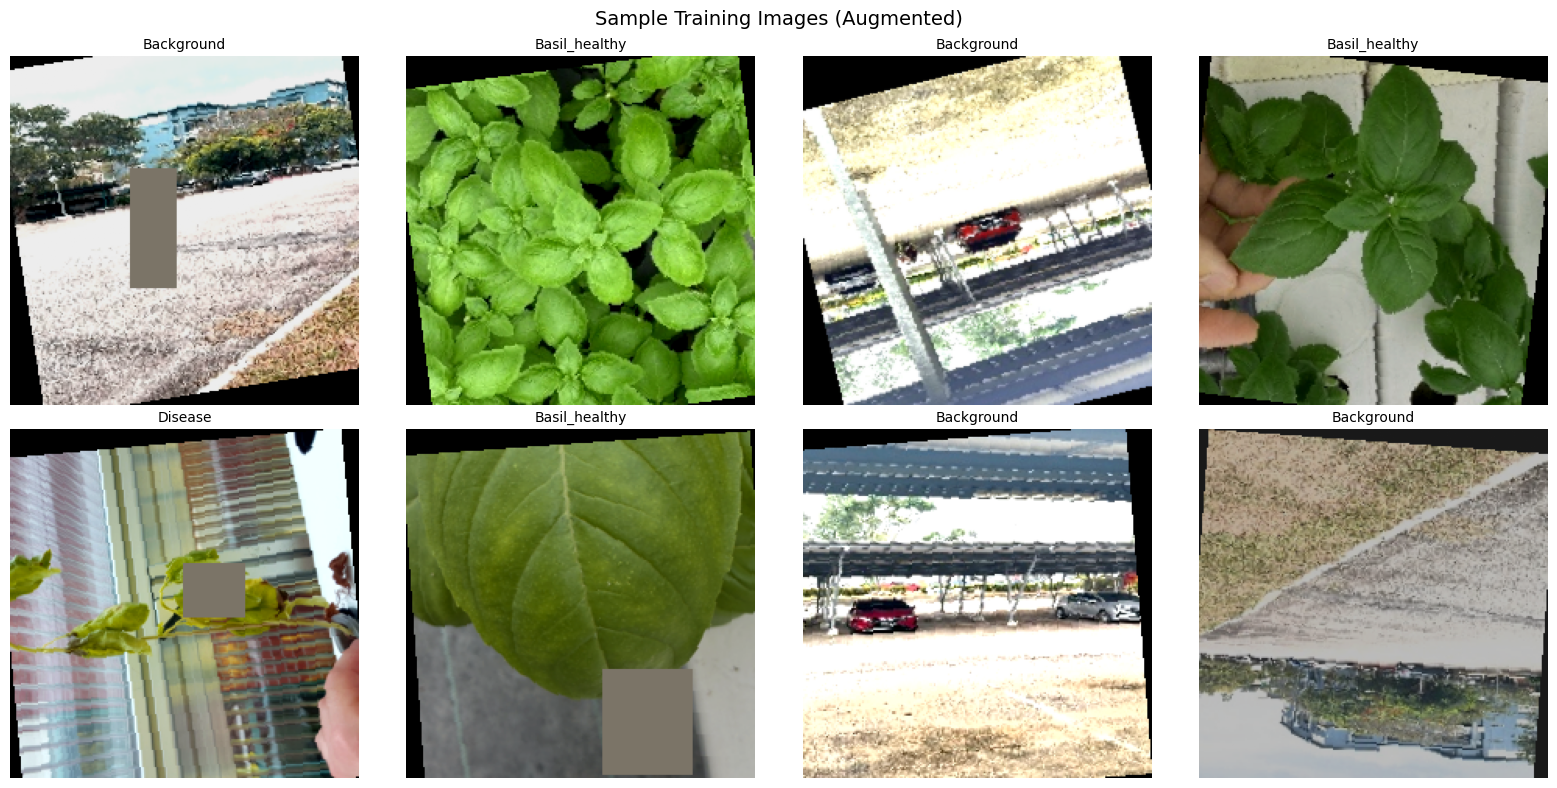

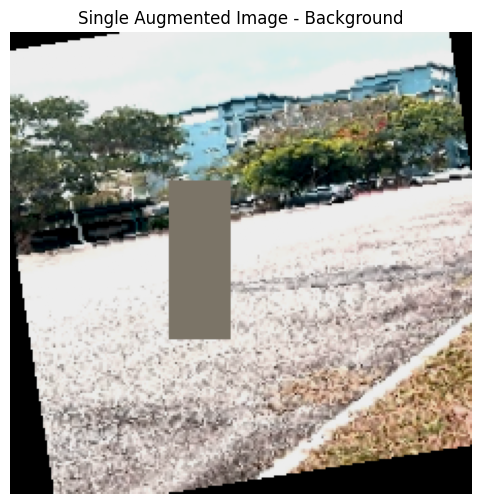

In [ ]:
def unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

img_batch, label_batch = next(iter(train_dataloader))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < len(img_batch):
        img = unnormalize(img_batch[i]).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.set_title(class_names[label_batch[i]], fontsize=10)
    ax.axis("off")
plt.suptitle("Sample Training Images (Augmented)", fontsize=14)
plt.tight_layout()
plt.savefig("sample_augmented_images.png", dpi=150)
plt.show()

# Single unnormalized image
plt.figure(figsize=(6, 6))
single_img = unnormalize(img_batch[0]).permute(1, 2, 0).numpy().clip(0, 1)
plt.imshow(single_img)
plt.title(f"Single Augmented Image - {class_names[label_batch[0]]}")
plt.axis("off")
plt.show()

Define MobileNetV2 Model

In [ ]:
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights

def Basil_MobileNet(num_classes, freeze_backbone=True):
    weights = MobileNet_V2_Weights.DEFAULT
    model = models.mobilenet_v2(weights=weights)

    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    classifier_in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=classifier_in_features, out_features=num_classes)
    )

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

model_test = Basil_MobileNet(num_classes=num_classes)
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)

print(f"\nModel: MobileNetV2")
print(f"Total parameters: {total_params / 1e6:.2f} M")
print(f"Trainable parameters: {trainable_params / 1e3:.2f} K")
print(f"Output classes: {num_classes} ({class_names})")

dummy = torch.randn(1, 3, 224, 224)
output = model_test(dummy)
print(f"Forward pass output shape: {output.shape} -> [batch_size, {num_classes} classes]")
del model_test

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 83.0MB/s]



Model: MobileNetV2
Total parameters: 2.23 M
Trainable parameters: 3.84 K
Output classes: 3 (['Background', 'Basil_healthy', 'Disease'])
Forward pass output shape: torch.Size([1, 3]) -> [batch_size, 3 classes]


Define Training Functions

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


def train_final(model, train_dataloader, val_dataloader, optimizer, scheduler,
                loss_fn, epochs, device, patience=5, save_path="best_model.pth"):
    print(f">>> Starting training... Model will be saved to '{save_path}'")

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_acc = test_step(model, val_dataloader, loss_fn, device)
        scheduler.step(val_loss)

        print(f"\nEpoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_loss < best_val_loss:
            print(f"✅ Val loss improved from {best_val_loss:.4f} to {val_loss:.4f}, saving...")
            torch.save(model.state_dict(), save_path)
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping after {epoch+1} epochs!")
            break

    model.load_state_dict(torch.load(save_path))
    print(f"\nTraining complete. Best model loaded from '{save_path}'.")
    return model, history

 Training (Single Stage, All Layers Unfrozen)

In [ ]:
print(">>> Training MobileNetV2 (All Layers Unfrozen)")

torch.manual_seed(42)

model = Basil_MobileNet(num_classes=num_classes, freeze_backbone=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
loss_fn = nn.CrossEntropyLoss()

finetuned_model, history = train_final(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
    patience=5,
    save_path="basil_real"
)

np.save("basil_mobilenet_history.npy", history)
print(">>> Training Complete!")

>>> Training MobileNetV2 (All Layers Unfrozen)
>>> Starting training... Model will be saved to 'basil_real'


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20 | Train Acc: 0.7802 | Val Acc: 0.9554 | Train Loss: 0.6816 | Val Loss: 0.2979
✅ Val loss improved from inf to 0.2979, saving...

Epoch 2/20 | Train Acc: 0.9024 | Val Acc: 0.9598 | Train Loss: 0.3077 | Val Loss: 0.1177
✅ Val loss improved from 0.2979 to 0.1177, saving...

Epoch 3/20 | Train Acc: 0.9546 | Val Acc: 0.9866 | Train Loss: 0.1737 | Val Loss: 0.0703
✅ Val loss improved from 0.1177 to 0.0703, saving...

Epoch 4/20 | Train Acc: 0.9659 | Val Acc: 0.9866 | Train Loss: 0.1261 | Val Loss: 0.0549
✅ Val loss improved from 0.0703 to 0.0549, saving...

Epoch 5/20 | Train Acc: 0.9611 | Val Acc: 0.9866 | Train Loss: 0.1287 | Val Loss: 0.0610
⚠️ No improvement. Patience: 1/5

Epoch 6/20 | Train Acc: 0.9607 | Val Acc: 0.9866 | Train Loss: 0.1278 | Val Loss: 0.0414
✅ Val loss improved from 0.0549 to 0.0414, saving...

Epoch 7/20 | Train Acc: 0.9657 | Val Acc: 0.9866 | Train Loss: 0.1019 | Val Loss: 0.0374
✅ Val loss improved from 0.0414 to 0.0374, saving...

Epoch 8/20 | Train Ac

Plot Training Curves

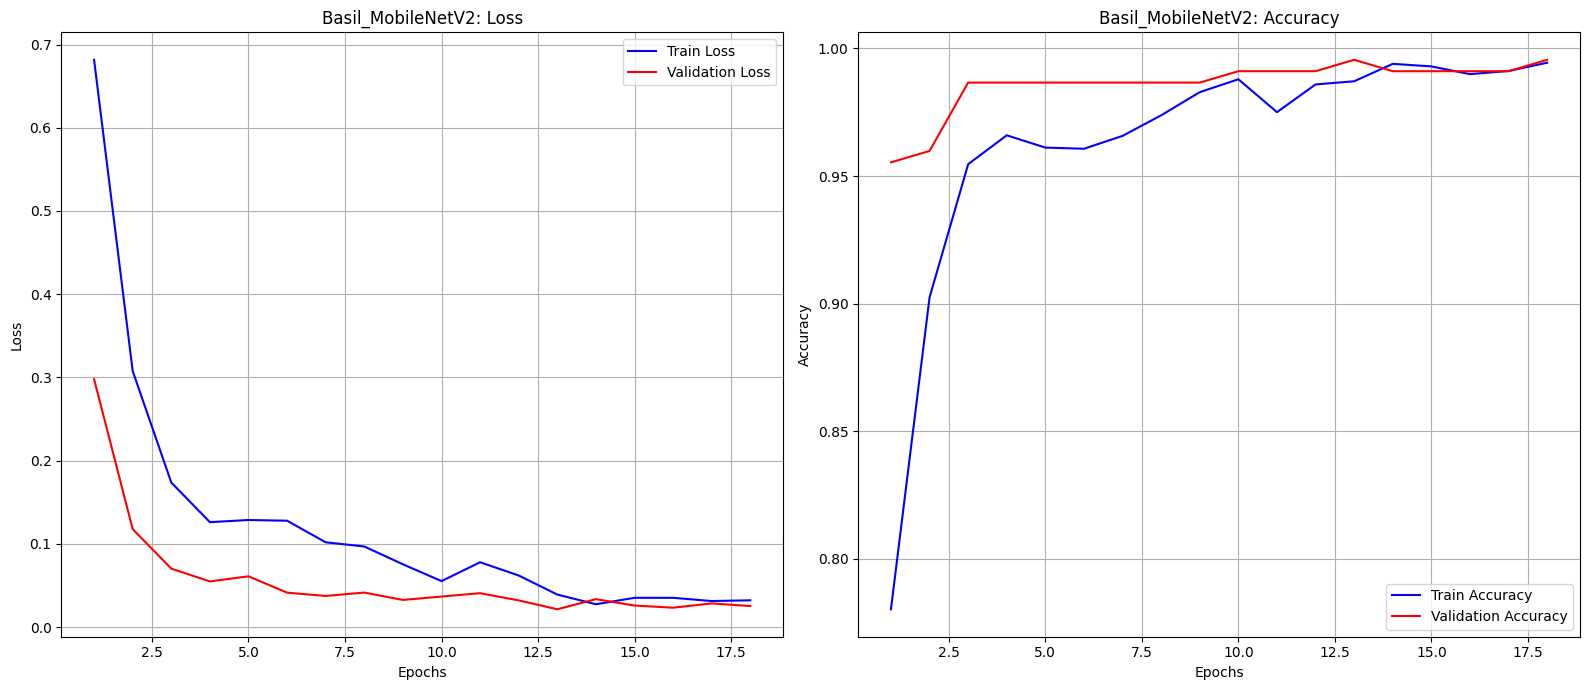

In [ ]:
def plot_training_curves(history, title_prefix=""):
    if isinstance(history, str):
        history = np.load(history, allow_pickle=True).item()

    epochs_ran = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_ran, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs_ran, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{title_prefix}: Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_ran, history['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(epochs_ran, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{title_prefix}: Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_curves_{title_prefix}.png', dpi=300)
    plt.show()

plot_training_curves(history, title_prefix="Basil_MobileNetV2")


Final Evaluation on Test Set

>>> Running final evaluation on TEST set...


  0%|          | 0/14 [00:00<?, ?it/s]


CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Background       1.00      1.00      1.00        70
Basil_healthy       1.00      1.00      1.00        65
      Disease       1.00      1.00      1.00        78

     accuracy                           1.00       213
    macro avg       1.00      1.00      1.00       213
 weighted avg       1.00      1.00      1.00       213

Overall Accuracy: 1.0000
Macro Avg F1-Score: 1.0000


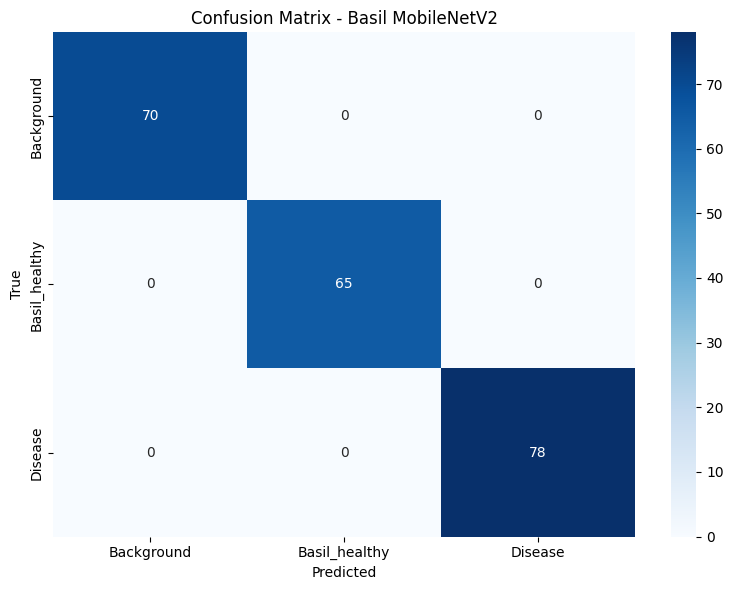

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(">>> Running final evaluation on TEST set...")
final_model = Basil_MobileNet(num_classes=num_classes).to(device)
final_model.load_state_dict(torch.load("basil_real", map_location=device))
final_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
print(f"Overall Accuracy: {report_dict['accuracy']:.4f}")
print(f"Macro Avg F1-Score: {report_dict['macro avg']['f1-score']:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Basil MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix_basil.png', dpi=300)
plt.show()


Efficiency Metrics

In [ ]:
import time

print("\n" + "=" * 50)
print("EFFICIENCY METRICS")
print("=" * 50)

model_path = "basil_real"
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
total_params_m = sum(p.numel() for p in final_model.parameters()) / 1e6

print(f"Model Size: {model_size_mb:.2f} MB")
print(f"Total Parameters: {total_params_m:.2f} M")

dummy_input = torch.randn(1, 3, 224, 224)
repetitions = 100

if device == "cuda":
    final_model.to("cuda")
    dummy_gpu = dummy_input.to("cuda")
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros(repetitions)
    for _ in range(10):
        _ = final_model(dummy_gpu)
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = final_model(dummy_gpu)
            ender.record()
            torch.cuda.synchronize()
            timings[rep] = starter.elapsed_time(ender)
    print(f"Average GPU inference time: {np.mean(timings):.2f} ms")

final_model.to("cpu")
dummy_cpu = dummy_input.to("cpu")
timings_cpu = np.zeros(repetitions)
for _ in range(10):
    _ = final_model(dummy_cpu)
with torch.no_grad():
    for rep in range(repetitions):
        start = time.time()
        _ = final_model(dummy_cpu)
        timings_cpu[rep] = (time.time() - start) * 1000
print(f"Average CPU inference time: {np.mean(timings_cpu):.2f} ms")


EFFICIENCY METRICS
Model Size: 8.73 MB
Total Parameters: 2.23 M
Average GPU inference time: 6.97 ms
Average CPU inference time: 28.40 ms


Confidence Threshold Analysis

In [ ]:
print("\n" + "=" * 50)
print("CONFIDENCE THRESHOLD ANALYSIS")
print("=" * 50)

final_model.to(device).eval()
all_probs, all_true_ct, all_preds_ct = [], [], []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = final_model(images)
        probs = torch.softmax(outputs, dim=1)
        confs, preds = probs.max(1)
        all_probs.extend(confs.cpu().numpy())
        all_true_ct.extend(labels.numpy())
        all_preds_ct.extend(preds.cpu().numpy())

all_probs = np.array(all_probs)
all_true_ct = np.array(all_true_ct)
all_preds_ct = np.array(all_preds_ct)

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
print(f"\n{'Threshold':<12}{'Accepted %':<14}{'Accuracy (accepted)':<22}{'Rejected %':<12}")
print("-" * 60)

for t in thresholds:
    mask = all_probs >= t
    accepted = mask.sum()
    if accepted > 0:
        acc = (all_preds_ct[mask] == all_true_ct[mask]).mean()
    else:
        acc = 0
    print(f"{t:<12.1f}{accepted/len(all_probs)*100:<14.1f}{acc*100:<22.1f}{(~mask).sum()/len(all_probs)*100:<12.1f}")


CONFIDENCE THRESHOLD ANALYSIS

Threshold   Accepted %    Accuracy (accepted)   Rejected %  
------------------------------------------------------------
0.5         99.5          100.0                 0.5         
0.6         98.6          100.0                 1.4         
0.7         98.6          100.0                 1.4         
0.8         98.1          100.0                 1.9         
0.9         97.2          100.0                 2.8         


Confidence Threshold Analysis (SCI Figure)

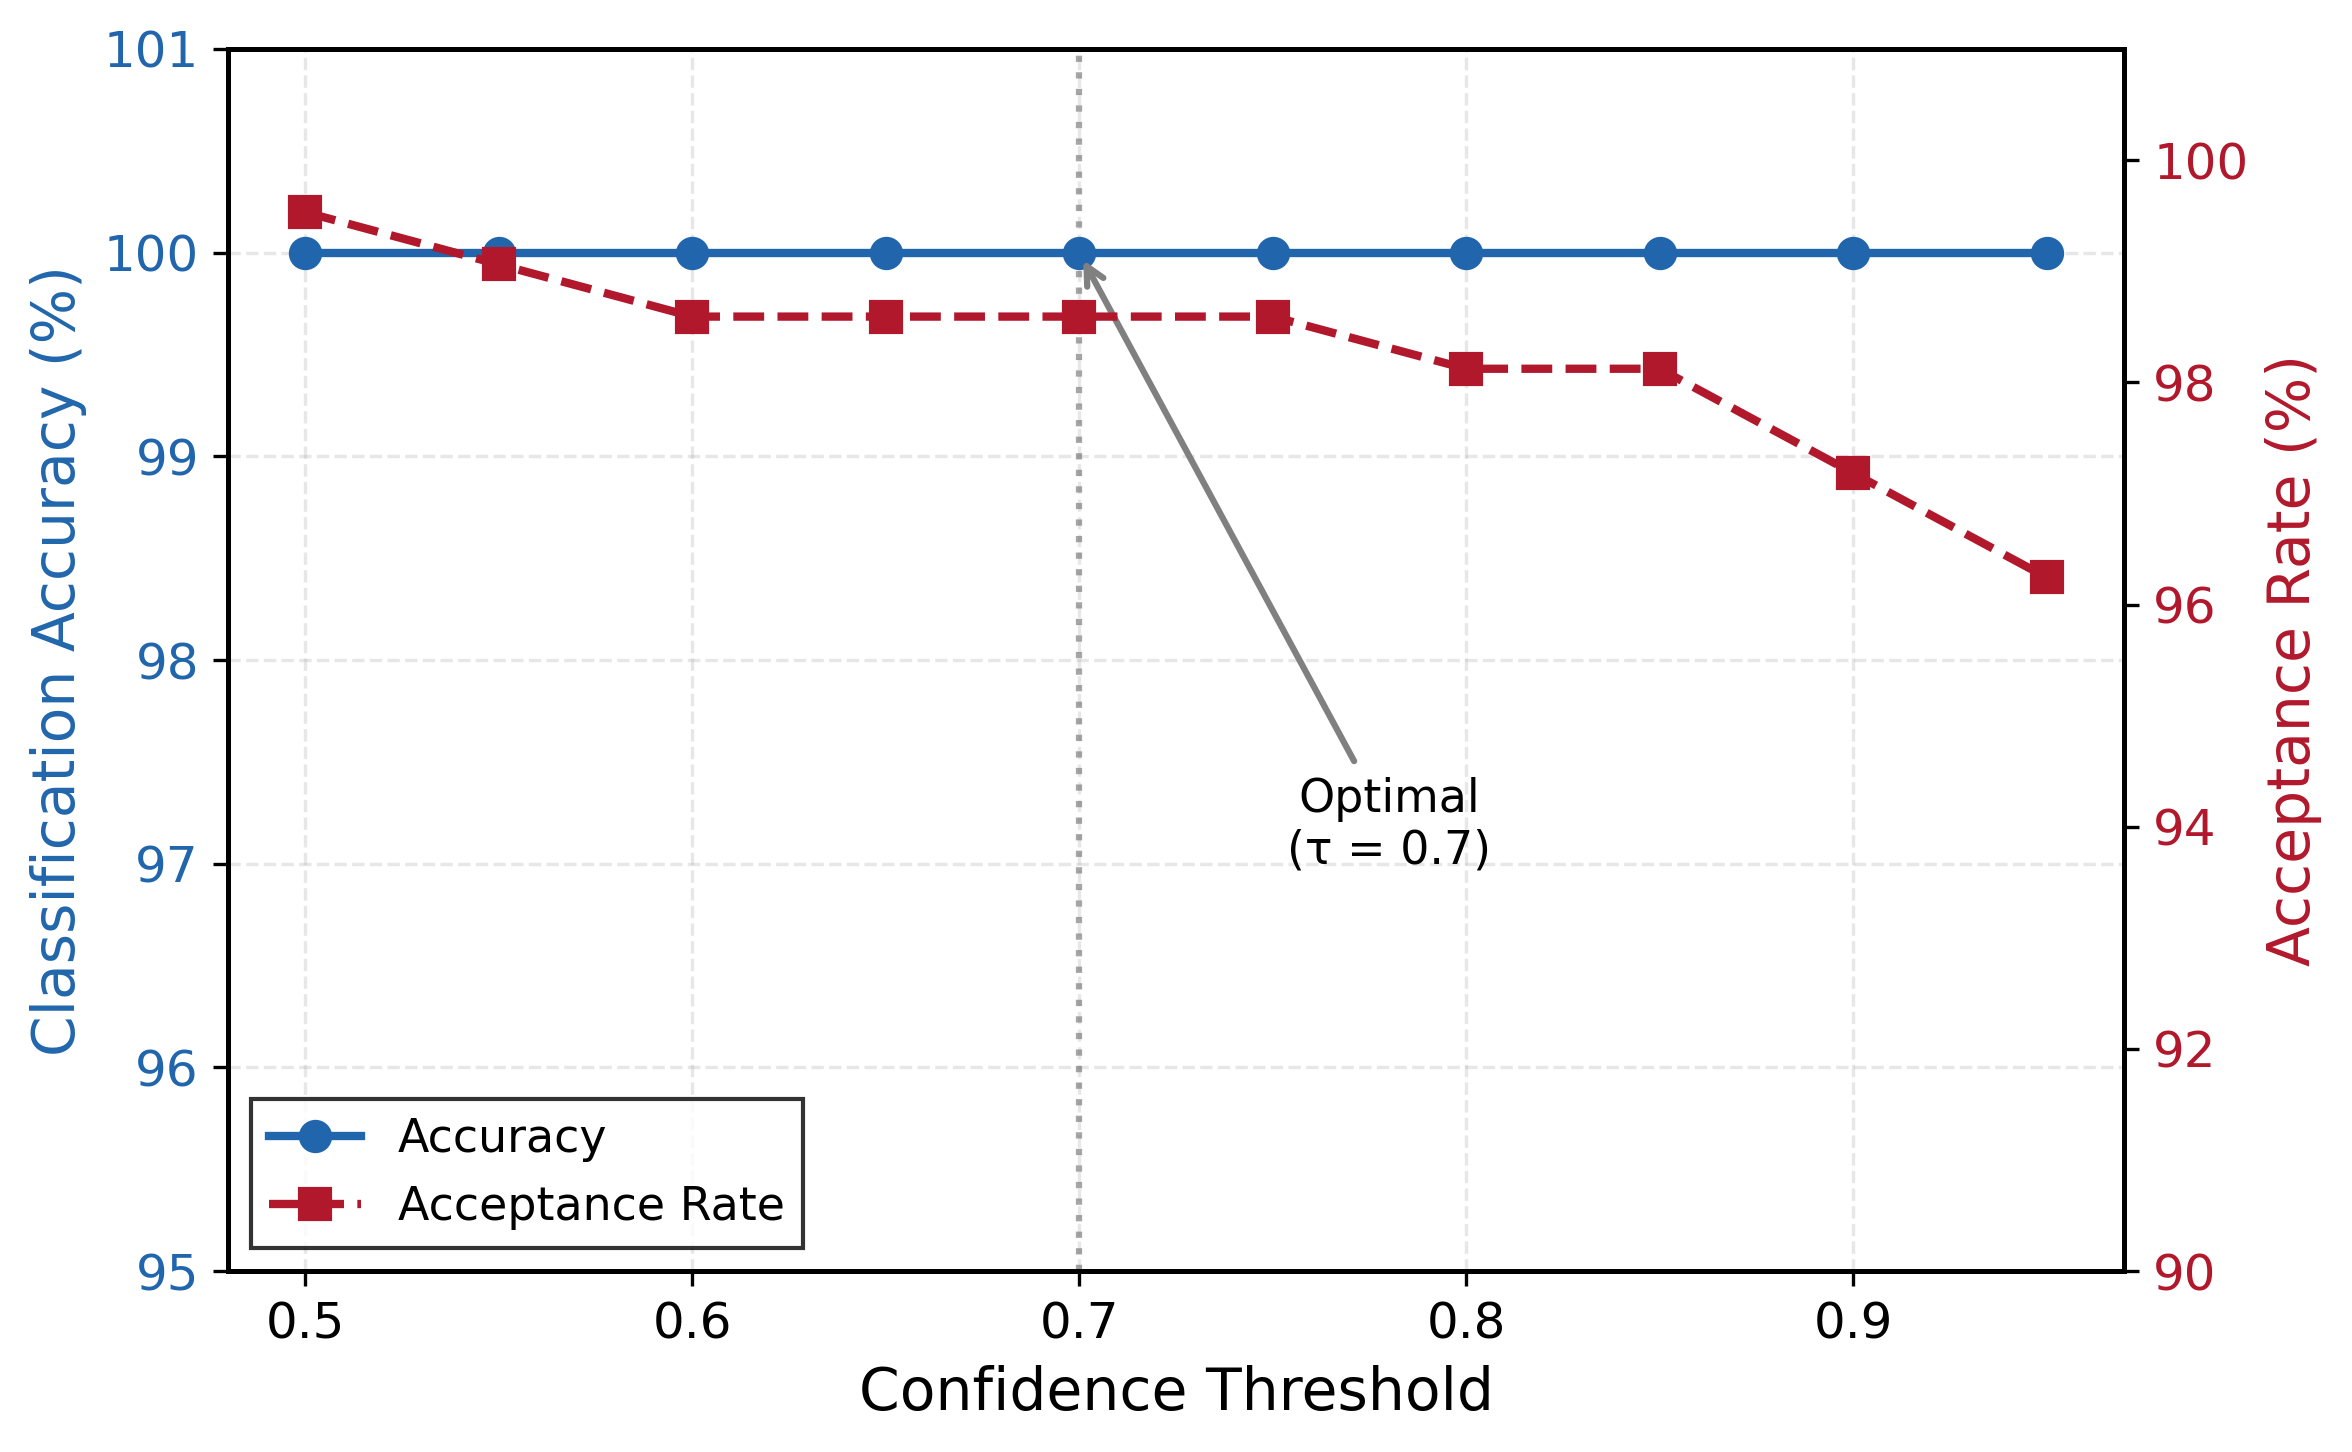

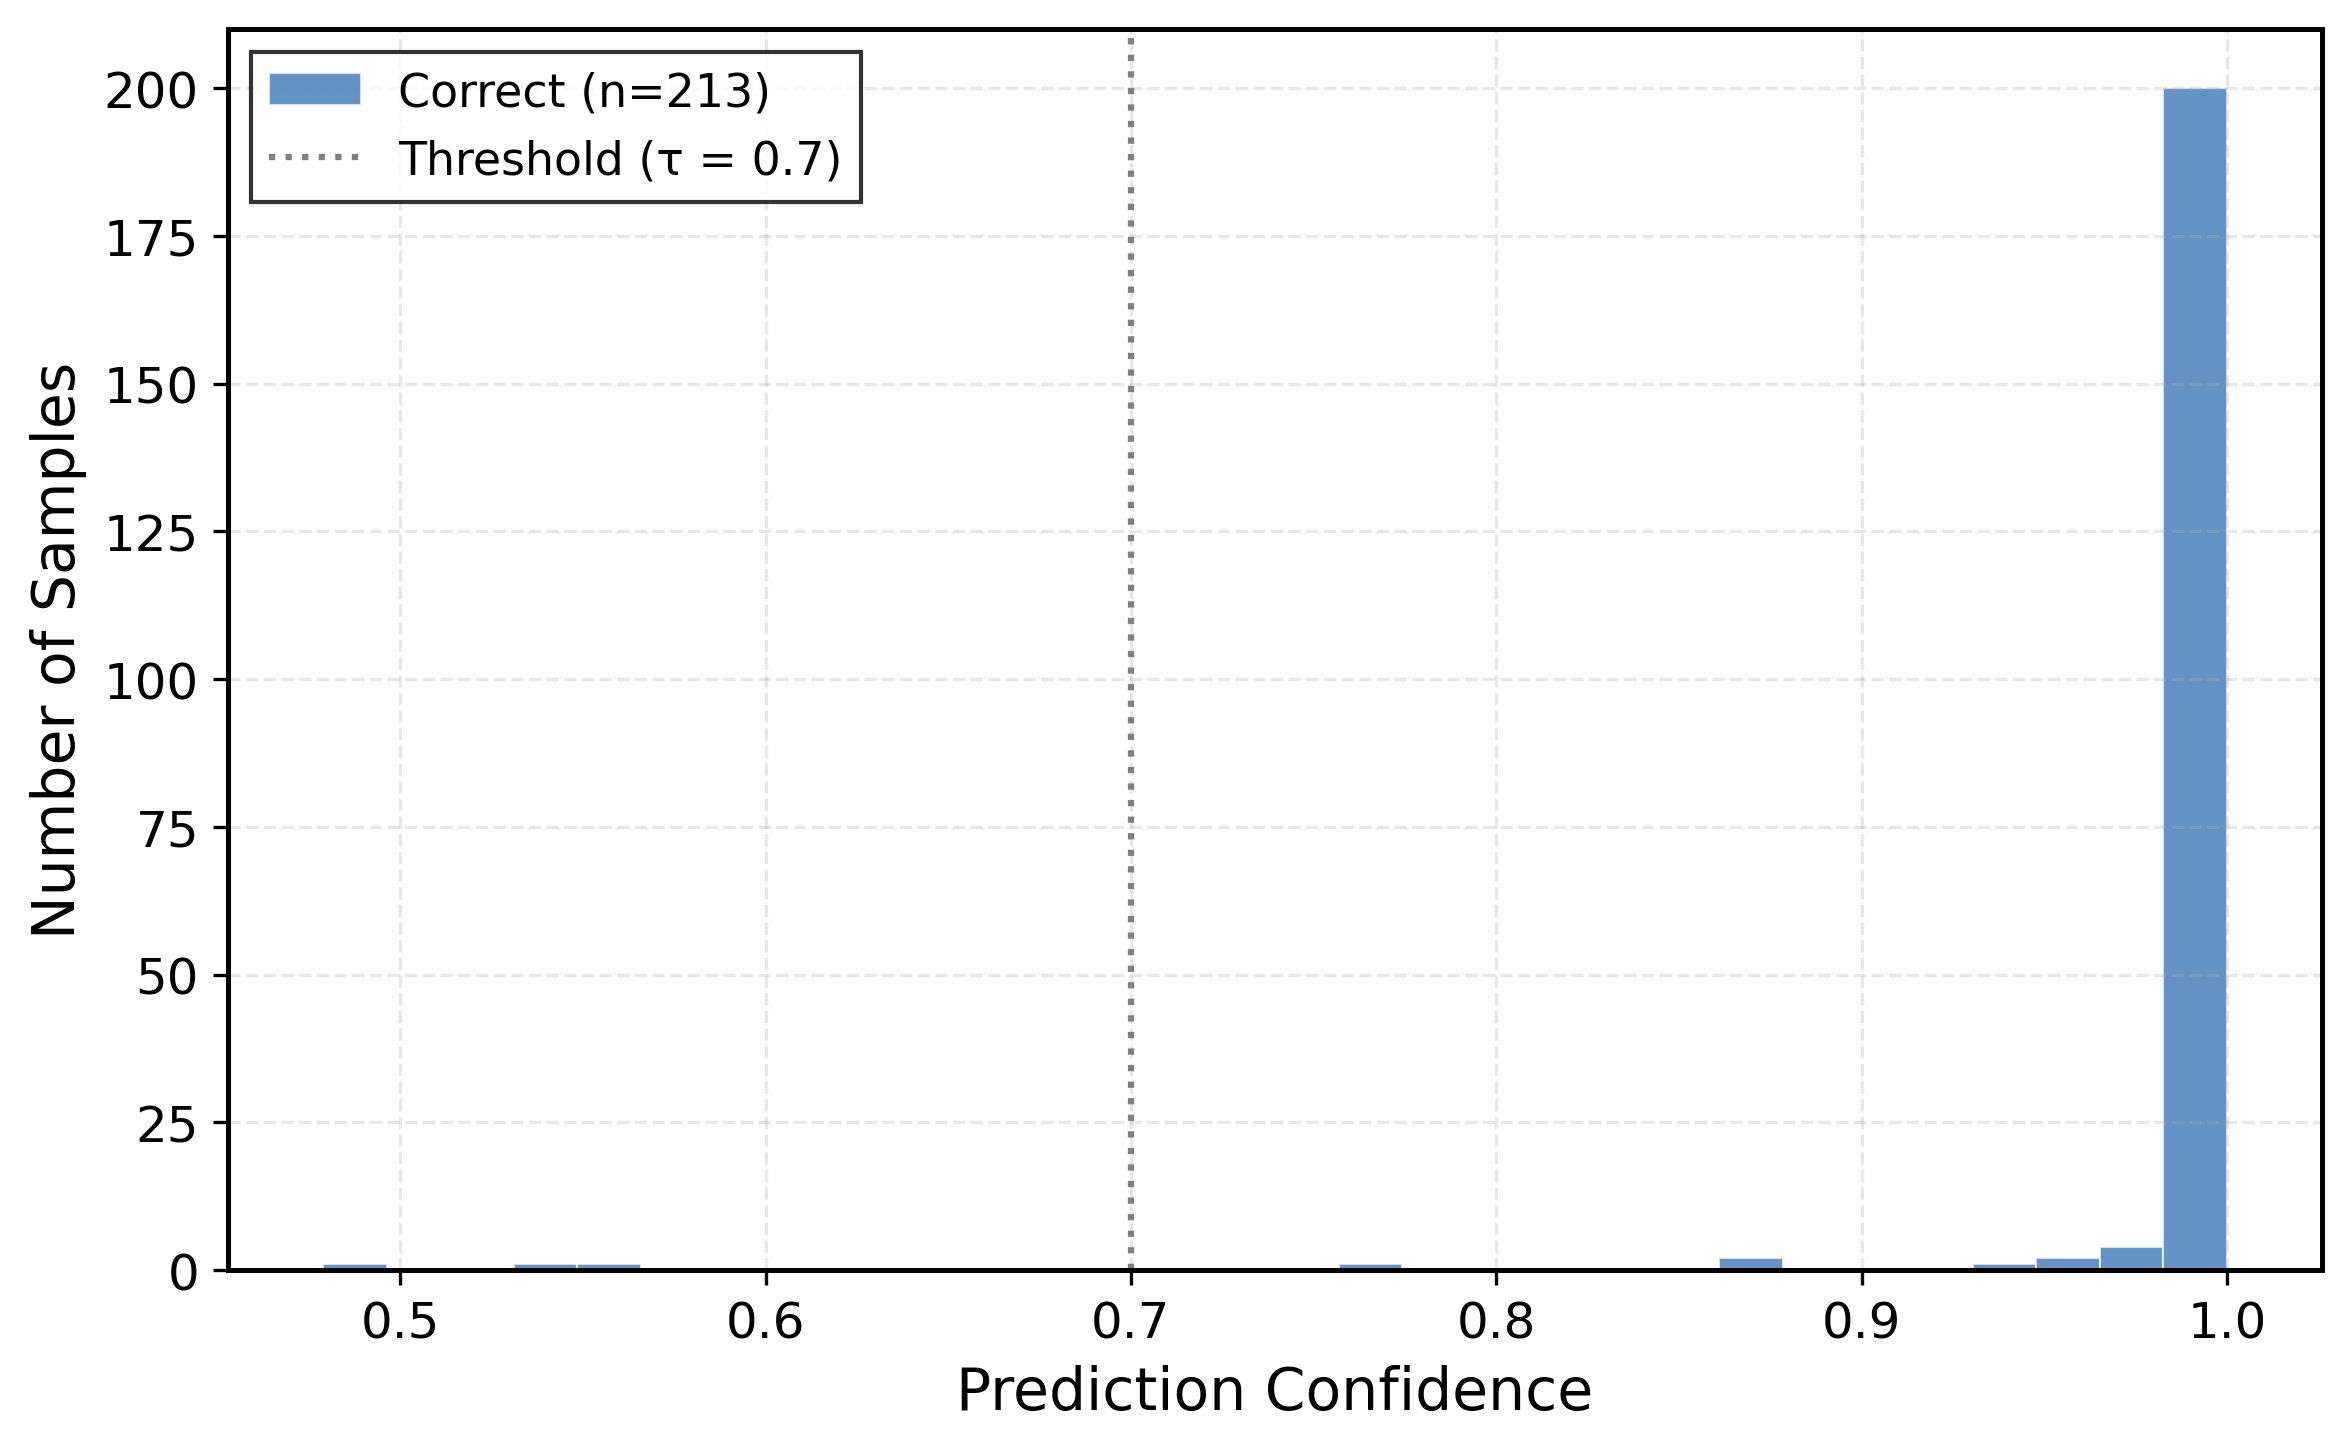


Table: Confidence Threshold Analysis
Threshold (τ)   Acceptance (%)    Accuracy (%)    Rejection (%)   
------------------------------------------------------------------
0.50            99.5              100.0           0.5             
0.55            99.1              100.0           0.9             
0.60            98.6              100.0           1.4             
0.65            98.6              100.0           1.4             
0.70            98.6              100.0           1.4             
0.75            98.6              100.0           1.4             
0.80            98.1              100.0           1.9             
0.85            98.1              100.0           1.9             
0.90            97.2              100.0           2.8             
0.95            96.2              100.0           3.8             


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Set SCI-quality plot style
matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.2,
})

# --- Run threshold analysis ---
final_model.to(device).eval()
all_probs, all_true_ct, all_preds_ct = [], [], []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = final_model(images)
        probs = torch.softmax(outputs, dim=1)
        confs, preds = probs.max(1)
        all_probs.extend(confs.cpu().numpy())
        all_true_ct.extend(labels.numpy())
        all_preds_ct.extend(preds.cpu().numpy())

all_probs = np.array(all_probs)
all_true_ct = np.array(all_true_ct)
all_preds_ct = np.array(all_preds_ct)

thresholds = np.arange(0.50, 0.96, 0.05)
accuracies = []
acceptance_rates = []
rejection_rates = []

for t in thresholds:
    mask = all_probs >= t
    accepted = mask.sum()
    if accepted > 0:
        acc = (all_preds_ct[mask] == all_true_ct[mask]).mean() * 100
    else:
        acc = 0
    accuracies.append(acc)
    acceptance_rates.append(accepted / len(all_probs) * 100)
    rejection_rates.append((~mask).sum() / len(all_probs) * 100)

# --- Figure 1: Dual-axis line plot ---
fig, ax1 = plt.subplots(figsize=(8, 5))

color_acc = '#2166AC'
color_accept = '#B2182B'

ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Classification Accuracy (%)', color=color_acc)
line1 = ax1.plot(thresholds, accuracies, 'o-', color=color_acc,
                 linewidth=2, markersize=7, label='Accuracy', zorder=3)
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_ylim(95, 101)
ax1.set_xlim(0.48, 0.97)

ax2 = ax1.twinx()
ax2.set_ylabel('Acceptance Rate (%)', color=color_accept)
line2 = ax2.plot(thresholds, acceptance_rates, 's--', color=color_accept,
                 linewidth=2, markersize=7, label='Acceptance Rate', zorder=3)
ax2.tick_params(axis='y', labelcolor=color_accept)
ax2.set_ylim(90, 101)

# Highlight optimal threshold
ax1.axvline(x=0.7, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.annotate('Optimal\n(τ = 0.7)', xy=(0.7, 100), xytext=(0.78, 97),
             fontsize=11, ha='center',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower left', frameon=True,
           edgecolor='black', fancybox=False)

ax1.grid(True, alpha=0.3, linestyle='--')
fig.tight_layout()
plt.savefig('fig_confidence_threshold.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_confidence_threshold.pdf', bbox_inches='tight')
plt.show()

# --- Figure 2: Confidence distribution histogram ---
fig, ax = plt.subplots(figsize=(8, 5))

correct_mask = all_preds_ct == all_true_ct
wrong_mask = ~correct_mask

ax.hist(all_probs[correct_mask], bins=30, alpha=0.7, color='#2166AC',
        label=f'Correct (n={correct_mask.sum()})', edgecolor='white', linewidth=0.5)
if wrong_mask.sum() > 0:
    ax.hist(all_probs[wrong_mask], bins=30, alpha=0.7, color='#B2182B',
            label=f'Incorrect (n={wrong_mask.sum()})', edgecolor='white', linewidth=0.5)

ax.axvline(x=0.7, color='gray', linestyle=':', linewidth=1.5, label='Threshold (τ = 0.7)')
ax.set_xlabel('Prediction Confidence')
ax.set_ylabel('Number of Samples')
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(True, alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('fig_confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_confidence_distribution.pdf', bbox_inches='tight')
plt.show()

# --- Print table for paper ---
print("\nTable: Confidence Threshold Analysis")
print(f"{'Threshold (τ)':<16}{'Acceptance (%)':<18}{'Accuracy (%)':<16}{'Rejection (%)':<16}")
print("-" * 66)
for i, t in enumerate(thresholds):
    print(f"{t:<16.2f}{acceptance_rates[i]:<18.1f}{accuracies[i]:<16.1f}{rejection_rates[i]:<16.1f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Efficiency Metrics (SCI Figure + Table)

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.2,
})

# --- Collect metrics ---
model_path = "/content/basil_real_proxy"
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
total_params_m = sum(p.numel() for p in final_model.parameters()) / 1e6

dummy_input = torch.randn(1, 3, 224, 224)
repetitions = 300

# GPU test
gpu_timings = None
if device == "cuda":
    final_model.to("cuda")
    dummy_gpu = dummy_input.to("cuda")
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    gpu_timings = np.zeros(repetitions)
    for _ in range(20):
        _ = final_model(dummy_gpu)
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = final_model(dummy_gpu)
            ender.record()
            torch.cuda.synchronize()
            gpu_timings[rep] = starter.elapsed_time(ender)

# CPU test
final_model.to("cpu")
dummy_cpu = dummy_input.to("cpu")
cpu_timings = np.zeros(repetitions)
for _ in range(20):
    _ = final_model(dummy_cpu)
with torch.no_grad():
    for rep in range(repetitions):
        start = time.time()
        _ = final_model(dummy_cpu)
        cpu_timings[rep] = (time.time() - start) * 1000

# --- Figure 1: Inference Latency Distribution (Box + Violin) ---
fig, ax = plt.subplots(figsize=(8, 5))

plot_data = []
plot_labels = []

if gpu_timings is not None:
    plot_data.append(gpu_timings)
    plot_labels.append('GPU\n(Colab T4)')
plot_data.append(cpu_timings)
plot_labels.append('CPU\n(Colab)')

vp = ax.violinplot(plot_data, positions=range(len(plot_data)),
                    showmeans=False, showmedians=False, showextrema=False)

colors = ['#2166AC', '#B2182B'] if gpu_timings is not None else ['#B2182B']
for i, body in enumerate(vp['bodies']):
    body.set_facecolor(colors[i])
    body.set_alpha(0.3)

bp = ax.boxplot(plot_data, positions=range(len(plot_data)),
                widths=0.15, patch_artist=True,
                boxprops=dict(linewidth=1.5),
                medianprops=dict(color='black', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5),
                flierprops=dict(marker='o', markersize=3, alpha=0.5))

for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i])
    patch.set_alpha(0.7)

ax.set_xticks(range(len(plot_labels)))
ax.set_xticklabels(plot_labels)
ax.set_ylabel('Inference Latency (ms)')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Add mean annotations
for i, data in enumerate(plot_data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    ax.annotate(f'{mean_val:.1f} ± {std_val:.1f} ms',
                xy=(i, mean_val), xytext=(i + 0.3, mean_val),
                fontsize=11, ha='left', va='center',
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.2))

fig.tight_layout()
plt.savefig('fig_inference_latency.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_inference_latency.pdf', bbox_inches='tight')
plt.show()

# --- Figure 2: Inference Latency Over Time (Stability) ---
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(range(repetitions), cpu_timings, '-', color='#B2182B',
        alpha=0.6, linewidth=0.8, label='CPU')
ax.axhline(y=np.mean(cpu_timings), color='#B2182B', linestyle='--',
           linewidth=1.5, label=f'CPU Mean ({np.mean(cpu_timings):.1f} ms)')

if gpu_timings is not None:
    ax.plot(range(repetitions), gpu_timings, '-', color='#2166AC',
            alpha=0.6, linewidth=0.8, label='GPU')
    ax.axhline(y=np.mean(gpu_timings), color='#2166AC', linestyle='--',
               linewidth=1.5, label=f'GPU Mean ({np.mean(gpu_timings):.1f} ms)')

ax.set_xlabel('Inference Iteration')
ax.set_ylabel('Latency (ms)')
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(True, alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('fig_inference_stability.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_inference_stability.pdf', bbox_inches='tight')
plt.show()

# --- Figure 3: Model Summary Bar Chart ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Model size
axes[0].bar(['MobileNetV2'], [model_size_mb], color='#2166AC', width=0.4, edgecolor='black', linewidth=0.8)
axes[0].set_ylabel('Model Size (MB)')
axes[0].text(0, model_size_mb + 0.3, f'{model_size_mb:.1f} MB', ha='center', fontsize=12, fontweight='bold')

# Parameters
axes[1].bar(['MobileNetV2'], [total_params_m], color='#4393C3', width=0.4, edgecolor='black', linewidth=0.8)
axes[1].set_ylabel('Parameters (M)')
axes[1].text(0, total_params_m + 0.05, f'{total_params_m:.2f} M', ha='center', fontsize=12, fontweight='bold')

# FPS
cpu_fps = 1000 / np.mean(cpu_timings)
axes[2].bar(['MobileNetV2'], [cpu_fps], color='#B2182B', width=0.4, edgecolor='black', linewidth=0.8)
axes[2].set_ylabel('Throughput (FPS)')
axes[2].text(0, cpu_fps + 0.5, f'{cpu_fps:.1f} FPS', ha='center', fontsize=12, fontweight='bold')

for ax in axes:
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_xlim(-0.5, 0.5)

fig.tight_layout()
plt.savefig('fig_model_summary.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_model_summary.pdf', bbox_inches='tight')
plt.show()

# --- Print table for paper ---
print("\n" + "=" * 60)
print("Table: Model Efficiency Metrics")
print("=" * 60)
print(f"{'Metric':<30}{'Value':<20}")
print("-" * 50)
print(f"{'Architecture':<30}{'MobileNetV2':<20}")
print(f"{'Input Resolution':<30}{'224 × 224':<20}")
print(f"{'Total Parameters':<30}{f'{total_params_m:.2f} M':<20}")
print(f"{'Model Size':<30}{f'{model_size_mb:.1f} MB':<20}")
if gpu_timings is not None:
    print(f"{'GPU Latency (mean ± std)':<30}{f'{np.mean(gpu_timings):.1f} ± {np.std(gpu_timings):.1f} ms':<20}")
    print(f"{'GPU Throughput':<30}{f'{1000/np.mean(gpu_timings):.1f} FPS':<20}")
print(f"{'CPU Latency (mean ± std)':<30}{f'{np.mean(cpu_timings):.1f} ± {np.std(cpu_timings):.1f} ms':<20}")
print(f"{'CPU Throughput':<30}{f'{cpu_fps:.1f} FPS':<20}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/basil_real_proxy'

Classification Report (SCI Figure + Table)

In [ ]:
# ============================================================
# Cell: Classification Report (SCI Figure + Table)
# ============================================================

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.2,
})

# --- Get predictions ---
final_model.to(device).eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)

# --- Figure 1: Confusion Matrix (SCI style) ---
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('(a) Confusion Matrix (Counts)')

# Normalized %
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': '%'},
            linewidths=0.5, linecolor='gray')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('(b) Confusion Matrix (Normalized %)')

fig.tight_layout()
plt.savefig('fig_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_confusion_matrix.pdf', bbox_inches='tight')
plt.show()

# --- Figure 2: Per-Class Metrics Bar Chart ---
metrics_data = {
    'Class': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Support': []
}

for cls in class_names:
    metrics_data['Class'].append(cls)
    metrics_data['Precision'].append(report_dict[cls]['precision'] * 100)
    metrics_data['Recall'].append(report_dict[cls]['recall'] * 100)
    metrics_data['F1-Score'].append(report_dict[cls]['f1-score'] * 100)
    metrics_data['Support'].append(int(report_dict[cls]['support']))

df_metrics = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, df_metrics['Precision'], width,
               label='Precision', color='#2166AC', edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x, df_metrics['Recall'], width,
               label='Recall', color='#4393C3', edgecolor='black', linewidth=0.8)
bars3 = ax.bar(x + width, df_metrics['F1-Score'], width,
               label='F1-Score', color='#B2182B', edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Class')
ax.set_ylabel('Score (%)')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, 115)
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('fig_classification_metrics.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_classification_metrics.pdf', bbox_inches='tight')
plt.show()

# --- Print table for paper ---
print("\n" + "=" * 70)
print("Table: Per-Class Classification Performance")
print("=" * 70)
print(f"{'Class':<20}{'Precision (%)':<16}{'Recall (%)':<14}{'F1-Score (%)':<16}{'Support':<10}")
print("-" * 70)
for _, row in df_metrics.iterrows():
    print(f"{row['Class']:<20}{row['Precision']:<16.1f}{row['Recall']:<14.1f}{row['F1-Score']:<16.1f}{row['Support']:<10d}")
print("-" * 70)
print(f"{'Overall Accuracy':<20}{report_dict['accuracy']*100:<16.1f}")
print(f"{'Macro Avg F1':<20}{report_dict['macro avg']['f1-score']*100:<16.1f}")
print(f"{'Weighted Avg F1':<20}{report_dict['weighted avg']['f1-score']*100:<16.1f}")

Real_proxy vs Real

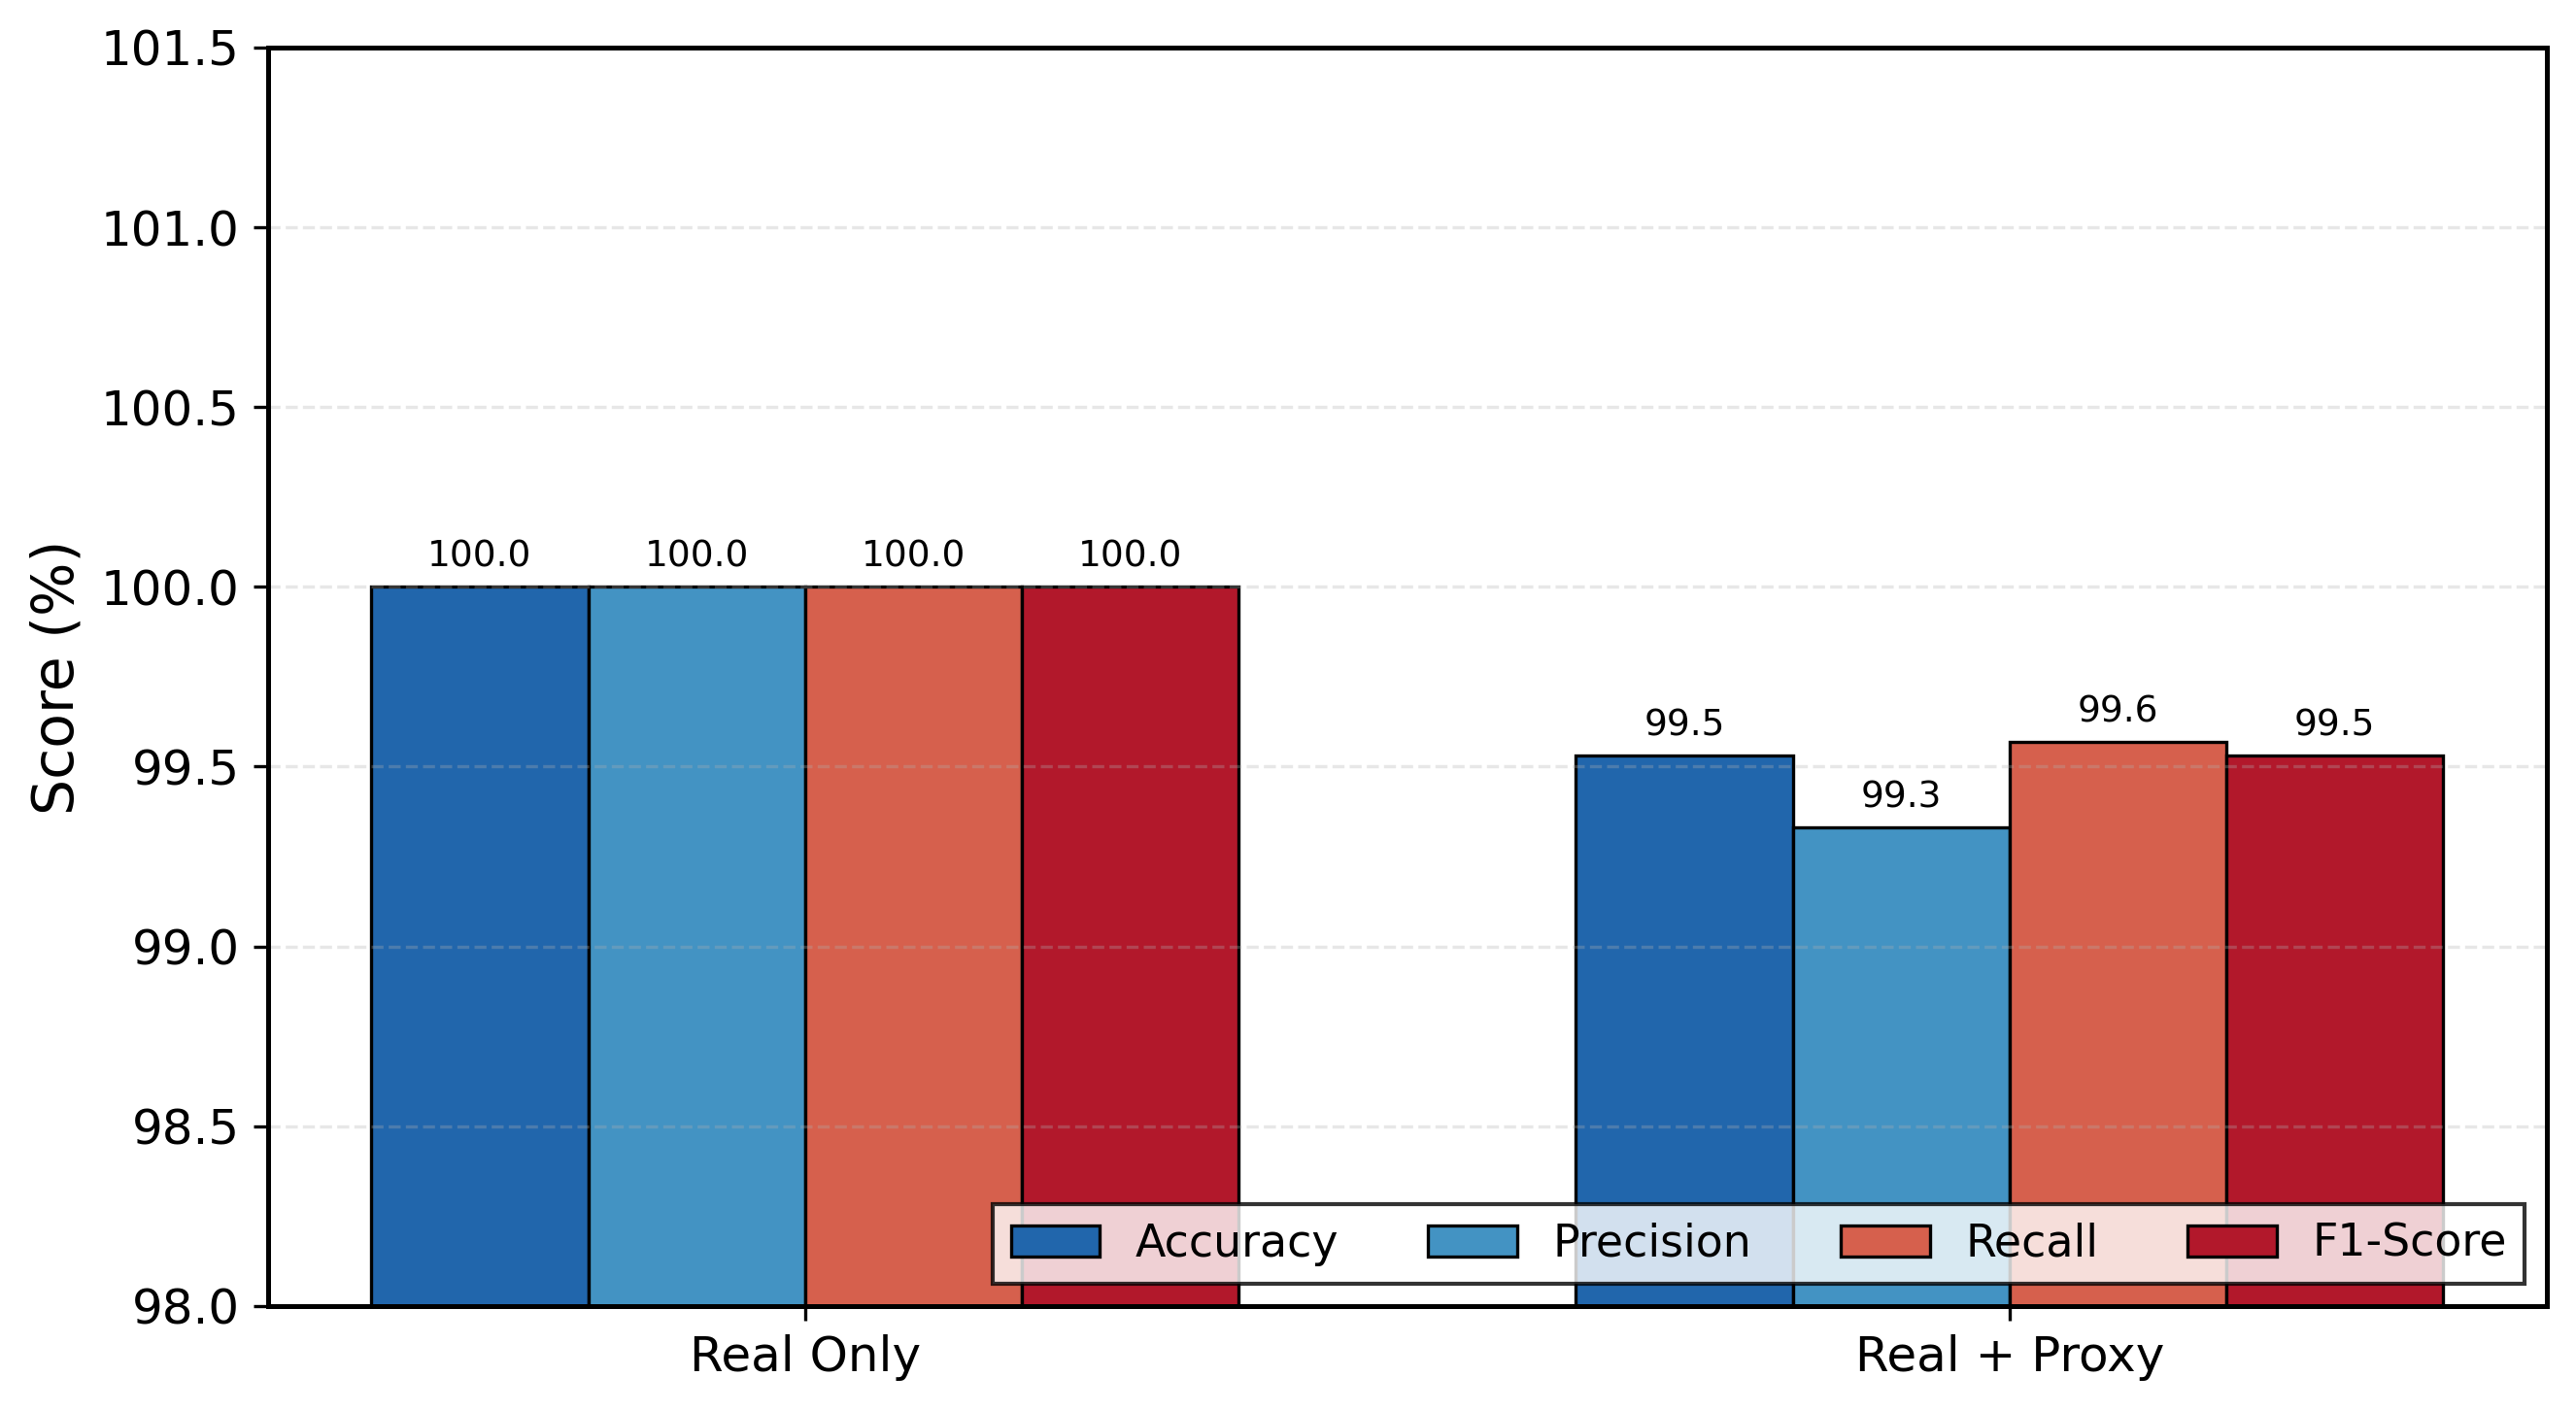


Table: Comparison of Data Strategies on MobileNetV2 Performance
Experiment          Accuracy (%)   Precision (%)  Recall (%)     F1-Score (%)   
---------------------------------------------------------------------------
Real Only           100.00         100.00         100.00         100.00         
Real + Proxy        99.53          99.33          99.57          99.53          


In [ ]:
# ============================================================
# Cell: Final Comparison (SCI Figure + Table)
# ============================================================
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.2,
})

# --- Fill in your results ---
experiments = ['Real Only', 'Real + Proxy']
accuracy =   [100.0, 99.53]
precision =  [100.0, 99.33]
recall =     [100.0, 99.57]
f1 =         [100.0, 99.53]

# --- Figure: Grouped Bar Chart ---
fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(experiments))
width = 0.18

bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy',
               color='#2166AC', edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision',
               color='#4393C3', edgecolor='black', linewidth=0.8)
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall',
               color='#D6604D', edgecolor='black', linewidth=0.8)
bars4 = ax.bar(x + 1.5*width, f1, width, label='F1-Score',
               color='#B2182B', edgecolor='black', linewidth=0.8)

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Score (%)')
ax.set_xticks(x)
ax.set_xticklabels(experiments)
ax.set_ylim(98, 101.5)
ax.legend(frameon=True, edgecolor='black', fancybox=False, ncol=4, loc='lower right')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('fig_experiment_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_experiment_comparison.pdf', bbox_inches='tight')
plt.show()

# --- Print table ---
print("\n" + "=" * 75)
print("Table: Comparison of Data Strategies on MobileNetV2 Performance")
print("=" * 75)
print(f"{'Experiment':<20}{'Accuracy (%)':<15}{'Precision (%)':<15}{'Recall (%)':<15}{'F1-Score (%)':<15}")
print("-" * 75)
print(f"{'Real Only':<20}{100.0:<15.2f}{100.0:<15.2f}{100.0:<15.2f}{100.0:<15.2f}")
print(f"{'Real + Proxy':<20}{99.53:<15.2f}{99.33:<15.2f}{99.57:<15.2f}{99.53:<15.2f}")

Export to ONNX for Raspberry Pi Deployment

In [ ]:
import torch

# Install onnxscript if not already installed
!pip install onnxscript

# Load best model
export_model = Basil_MobileNet(num_classes=num_classes, freeze_backbone=False)
export_model.load_state_dict(torch.load("/content/basil_real", map_location="cpu"))
export_model.eval()

# Export
dummy_input = torch.randn(1, 3, 224, 224)
onnx_path = "basil_mobilenet.onnx"

torch.onnx.export(
    export_model,
    dummy_input,
    onnx_path,
    opset_version=13,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 18.3 MB/s eta 0:00:00


/tmp/ipython-input-222/660217382.py:15: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0226 08:27:52.550000 222 torch/onnx/_internal/exporter/_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0226 08:27:53.667000 222 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, a

[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/lib/python3.12/copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 120, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 115, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.10.0+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[batch_size,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[batch_size,3]>
            ),
            initializers=(
                %"features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"features.1.conv.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"features.1.conv.1.weight"<FLOAT,[16,32,1,1]>{Tensor(...)},
                %"features.2.conv.1.0.weight"<FLOAT,[96,1,3,3]>{Tensor(...)},
                %"classifier.1.bias"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(Parameter containing: tensor([ 0.0113,  0.0123, -0.0228], requires_grad=True), name='classifier.1.bias')},
                %"feature

Save Everything to Google Drive

In [ ]:
import shutil

destination = "/content/drive/MyDrive/Final_aia/Real_Dataset"
os.makedirs(destination, exist_ok=True)

files_to_save = [
    # Models
    "/content/basil_real_only",
    "basil_mobilenet.onnx",
    # History
    "basil_mobilenet_history.npy",
    # Figures
    "confusion_matrix_basil.png",
    "fig_classification_metrics.png",
    "fig_confidence_distribution.png",
    "fig_confidence_threshold.png",
    "fig_confusion_matrix.png",
    "fig_inference_latency.png",
    "fig_inference_stability.png",
    "fig_model_summary.png",
    "sample_augmented_images.png",
    "training_curves_Basil_MobileNetV2.png",
]
print(">>> Saving to Google Drive (Final_aia/)...")
for f in files_to_save:
    if os.path.exists(f):
        shutil.copy(f, destination)
        print(f"  ✅ {f}")
    else:
        print(f"  ⚠️ {f} not found")

# Save class names
import json
class_dict = {name: idx for idx, name in enumerate(class_names)}
with open(os.path.join(destination, "class_names.json"), "w") as f:
    json.dump(class_dict, f, indent=2)
print("  ✅ class_names.json")

print(f"\n>>> All saved to: {destination}")

>>> Saving to Google Drive (Final_aia/)...
  ⚠️ /content/basil_real_only not found
  ✅ basil_mobilenet.onnx
  ✅ basil_mobilenet_history.npy
  ✅ confusion_matrix_basil.png
  ⚠️ fig_classification_metrics.png not found
  ✅ fig_confidence_distribution.png
  ✅ fig_confidence_threshold.png
  ⚠️ fig_confusion_matrix.png not found
  ⚠️ fig_inference_latency.png not found
  ⚠️ fig_inference_stability.png not found
  ⚠️ fig_model_summary.png not found
  ✅ sample_augmented_images.png
  ✅ training_curves_Basil_MobileNetV2.png


KeyboardInterrupt: 